# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [5]:
#import required libraries
import wptools
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt


In [6]:
#read the first file in a dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [7]:
#read text from URL
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#Save text to file

with open('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [10]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# use the array 'data' to store the lines from the json

data = []

for line in open ('tweet_json.txt', 'r'):
    tweets = json.loads(line)
    data.append({'tweet_id': tweets['id_str'],
                        'retweet_count': tweets['retweet_count'],
                        'favorite_count': tweets['favorite_count'],
                        'followers_count': tweets['user']['followers_count']})

In [11]:
#check if the data array looks good
add = pd.DataFrame(data)
add.head()

,favorite_count,followers_count,retweet_count,tweet_id
0,39467,3200889,8853,892420643555336193
1,33819,3200889,6514,892177421306343426
2,25461,3200889,4328,891815181378084864
3,42908,3200889,8964,891689557279858688
4,41048,3200889,9774,891327558926688256


In [12]:
#save the data in the datafram 'additional_tweets'
additional_tweets = pd.DataFrame(data)
additional_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count     2354 non-null int64
followers_count    2354 non-null int64
retweet_count      2354 non-null int64
tweet_id           2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



The following command will analyse the twitter_archive dataframe:

In [13]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [219]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [220]:
twitter_archive.groupby('rating_numerator').size()

rating_numerator
0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
dtype: int64

In [221]:
twitter_archive.groupby('rating_denominator').size()

rating_denominator
0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
dtype: int64

In [222]:
twitter_archive[['doggo','floofer','pupper','puppo']]

,doggo,floofer,pupper,puppo
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
5,None,None,None,None
6,None,None,None,None
7,None,None,None,None
8,None,None,None,None
9,doggo,None,None,None


In [223]:
twitter_archive.isna()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
1,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
2,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
4,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
5,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
6,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
7,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
8,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False
9,False,True,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False


The following command will analyse the 'image_predictions' dataframe:

In [224]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [225]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The following command will analyse the 'additional_tweets' dataframe:

In [226]:
additional_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
favorite_count     2354 non-null int64
followers_count    2354 non-null int64
retweet_count      2354 non-null int64
tweet_id           2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [227]:
additional_tweets.head()

,favorite_count,followers_count,retweet_count,tweet_id
0,39467,3200889,8853,892420643555336193
1,33819,3200889,6514,892177421306343426
2,25461,3200889,4328,891815181378084864
3,42908,3200889,8964,891689557279858688
4,41048,3200889,9774,891327558926688256


### Quality issues
1. Issues in twitter_archive: <br>

1.1 Remove retweet columns: 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'<br>
1.2 Change 'timestamp' datatype to datetime<br>
1.3 Remove columns as there are many "N/A": 'in_reply_to_status_id', 'in_reply_to_user_id'<br>
1.4 Remove outliers in 'rating_numerator' and in 'rating_denominator' (>100 and = 0)<br>
1.5 Change datatype in 'tweet_id' to object<br>
1.6 Rename column 'floofer' to 'floof'<br>

2. Issues in image_predictions:<br>

2.1 Change all dog type to lower case in columns: 'p1', 'p2', 'p3'<br>
2.2 Change datatype in 'tweet_id' to object<br>

3. Issues in additional_tweets visual: none<br>

### Tidiness issues
1. In twitter_archive: Merge columns 'doggo', 'floof', 'pupper' and 'puppo' to single column 'description'

2. All tables: Merge all tables into one table with 'tweet_id' as identifier

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [66]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
additional_tweets_clean =  additional_tweets.copy()

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Issue #1:

#### 1.1 Remove retweet columns: 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'

#### Code

In [67]:
#drop the retweet columns and set them first to null
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_user_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_timestamp.isnull()]

twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

#### Test

In [68]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


### Issue #2:

#### 1.2 Change 'timestamp' datatype to datetime

#### Code

In [69]:
#convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#### Test

In [70]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 254.9+ KB


### Issue #3:

#### 1.3 Remove columns as there are many "N/A": 'in_reply_to_status_id', 'in_reply_to_user_id'<br>

#### Code

In [71]:
#drop the columns with 'N/A' and set them to null first
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_user_id.isnull()]

twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

#### Test

In [72]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


### Issue #4:

#### 1.4 Remove outliers in 'rating_numerator' and in 'rating_denominator' (>100 and = 0)

#### Code

In [73]:
#drop the outlier rows:
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['rating_denominator'] == 0].index)
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['rating_denominator'] > 100].index)
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['rating_numerator'] == 0].index)
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['rating_numerator'] > 100].index)

#### Test

In [74]:
twitter_archive_clean.describe()

,tweet_id,rating_numerator,rating_denominator
count,2.090000e+03,2090.000000,2090.000000
mean,7.365825e+17,10.876077,10.206220
std,6.713954e+16,4.622406,3.499717
min,6.660209e+17,1.000000,2.000000
25%,6.768137e+17,10.000000,10.000000
50%,7.097095e+17,11.000000,10.000000
75%,7.877873e+17,12.000000,10.000000
max,8.924206e+17,99.000000,90.000000


### Issue #5:

#### 1.5 change datatype in 'tweet_id' to object

#### Code

In [75]:
#change the dataype
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')

#### Test

In [76]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  2090 non-null object
doggo                 2090 non-null object
floofer               2090 non-null object
pupper                2090 non-null object
puppo                 2090 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 212.3+ KB


### Issue #6:

#### 1.6 Rename column 'floofer' to 'floof'

#### Code

In [77]:
twitter_archive_clean.rename(columns={"floofer": "floof"}, inplace=True)

#### Test

In [78]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  2090 non-null object
doggo                 2090 non-null object
floof                 2090 non-null object
pupper                2090 non-null object
puppo                 2090 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 212.3+ KB


### Issue #7:

#### 2.1 Change all dog type to lower case in columns: 'p1', 'p2', 'p3'

#### Code

In [79]:
#set all names to lower case
image_predictions_clean['p1'] = image_predictions_clean['p1'].str.lower()
image_predictions_clean['p2'] = image_predictions_clean['p2'].str.lower()
image_predictions_clean['p3'] = image_predictions_clean['p3'].str.lower()

#### Test

In [81]:
#check if there is any upper case (should be zero)
image_predictions_clean[image_predictions_clean.p1.str.isupper() == True].count()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

### Issue #8:

#### 2.2 Change datatype in 'tweet_id' to object<br>

#### Code

In [82]:
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype('str')

#### Test

In [83]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Issue #9:

#### In twitter_archive: Merge columns 'doggo', 'floof', 'pupper' and 'puppo' to single column 'description'

#### Code

In [84]:
#replace all the 'none' values to blank ''
twitter_archive_clean[['doggo','floof','pupper','puppo']] = twitter_archive_clean[['doggo','floof','pupper','puppo']].replace(to_replace='None', value='')

#add a new colum 'description' which is the concatenation of the the columns 'doggo','floof','pupper','puppo'
twitter_archive_clean['description'] = twitter_archive_clean.doggo + twitter_archive_clean.floof + twitter_archive_clean.pupper + twitter_archive_clean.puppo

#drop the unused columns 'doggo','floof','pupper','puppo'
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floof', 'pupper', 'puppo'], axis = 1)

twitter_archive_clean['description'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [85]:
#separate the concenated names with a comma
twitter_archive_clean.loc[twitter_archive_clean.description == 'doggopupper', 'description'] = 'doggo, pupper' 
twitter_archive_clean.loc[twitter_archive_clean.description == 'doggopuppo', 'description'] = 'doggo, puppo' 
twitter_archive_clean.loc[twitter_archive_clean.description == 'doggofloofer', 'description'] = 'doggo, floofer'

#### Test

In [86]:
twitter_archive_clean['description'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

### Issue #10:

#### All tables: Merge all tables into one table with 'tweet_id' as identifier

#### Code

In [87]:
#join thhe frames twitter_archive_clean and additional_tweets_clean to a new column 'temp'
temp = twitter_archive_clean.join(additional_tweets_clean.set_index('tweet_id'), on='tweet_id')

#join 'temp' and image_predictions_clean to 'master data'
master_data = temp.join(image_predictions_clean.set_index('tweet_id'), on='tweet_id')

#### Test

In [88]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2355
Data columns (total 23 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  2090 non-null object
description           2090 non-null object
favorite_count        2090 non-null int64
followers_count       2090 non-null int64
retweet_count         2090 non-null int64
jpg_url               1964 non-null object
img_num               1964 non-null float64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null object
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null object
p3                    1964 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [89]:
master_data.to_csv(path_or_buf='twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [90]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2355
Data columns (total 23 columns):
tweet_id              2090 non-null object
timestamp             2090 non-null datetime64[ns]
source                2090 non-null object
text                  2090 non-null object
expanded_urls         2087 non-null object
rating_numerator      2090 non-null int64
rating_denominator    2090 non-null int64
name                  2090 non-null object
description           2090 non-null object
favorite_count        2090 non-null int64
followers_count       2090 non-null int64
retweet_count         2090 non-null int64
jpg_url               1964 non-null object
img_num               1964 non-null float64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null object
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null object
p3                    1964 

In [91]:
master_data.describe()

,rating_numerator,rating_denominator,favorite_count,followers_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,2090.000000,2090.000000,2090.000000,2.090000e+03,2090.000000,1964.000000,1964.000000,1.964000e+03,1.964000e+03
mean,10.876077,10.206220,8984.574163,3.200945e+06,2842.965550,1.201629,0.594645,1.348319e-01,6.019416e-02
std,4.622406,3.499717,12213.265754,4.420793e+01,4716.650013,0.558432,0.272174,1.011289e-01,5.100273e-02
min,1.000000,2.000000,81.000000,3.200799e+06,16.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,2044.250000,3.200901e+06,641.500000,1.000000,0.362903,5.352722e-02,1.605498e-02
50%,11.000000,10.000000,4186.500000,3.200947e+06,1402.500000,1.000000,0.587797,1.175870e-01,4.933745e-02
75%,12.000000,10.000000,11443.000000,3.201001e+06,3285.000000,1.000000,0.848400,1.960392e-01,9.157912e-02
max,99.000000,90.000000,132810.000000,3.201018e+06,79515.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [92]:
master_data.description.unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [94]:
#we saw above that the maximum of favorite counts is 132810. Let's have a look at this specific entry:
master_data.query('favorite_count == 132810')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,description,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
413,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,10,None,puppo,132810,...,1.0,lakeland_terrier,0.196015,True,labrador_retriever,0.160329,True,irish_terrier,0.069126,True


### Insights:
1. Most of the ratings are between 10/10 and 12/10, which is a not very meaningfull comparison scale. The rating seems to be purely subjective, as every dog (of course) has an above-the-scale rating (>10) .

2. The first prediction (p1) has on average the highest confidence (59.5%).

3. The most favorite tweet (dog breed is predicted as a 'lakeland_terrier') had 132810 likes with a rating of 13/10.

### Visualization

 The following chart shows an additional (visual) insight. A plot where we see the distribution of the counts of WeRateDogs ratings:

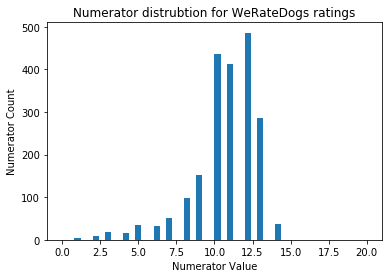

In [96]:
n_bins = 50
plt.hist(master_data['rating_numerator'],range=[0, 20],bins=n_bins)

plt.title('Numerator distrubtion for WeRateDogs ratings')
plt.xlabel('Numerator Value')
plt.ylabel('Numerator Count');

Another chart shows the amount of different type of dog descriptions:

Text(0,0.5,'Count of Descriptions')

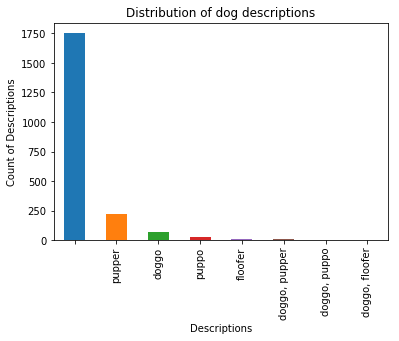

In [126]:
ax = master_data.description.value_counts().plot(kind='bar',title='Distribution of dog descriptions')

ax.set_xlabel('Descriptions')
ax.set_ylabel('Count of Descriptions')